## Imports

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from dataset.image_dataset import ImageDataset

## Setup

In [35]:
# Specify the device
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
if torch.backends.mps.is_available():
    device = 'mps'

# Load the model and map it to the GPU
model = torch.load("saved_models/model.pth", map_location=device)

# Set the model to evaluation mode
model.eval()

print("Model loaded onto", device)

Model loaded onto mps


/var/folders/5m/5hqxry713v946xwvr21xjx180000gn/T/ipykernel_7625/728108199.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("saved_models/model.pth", ma

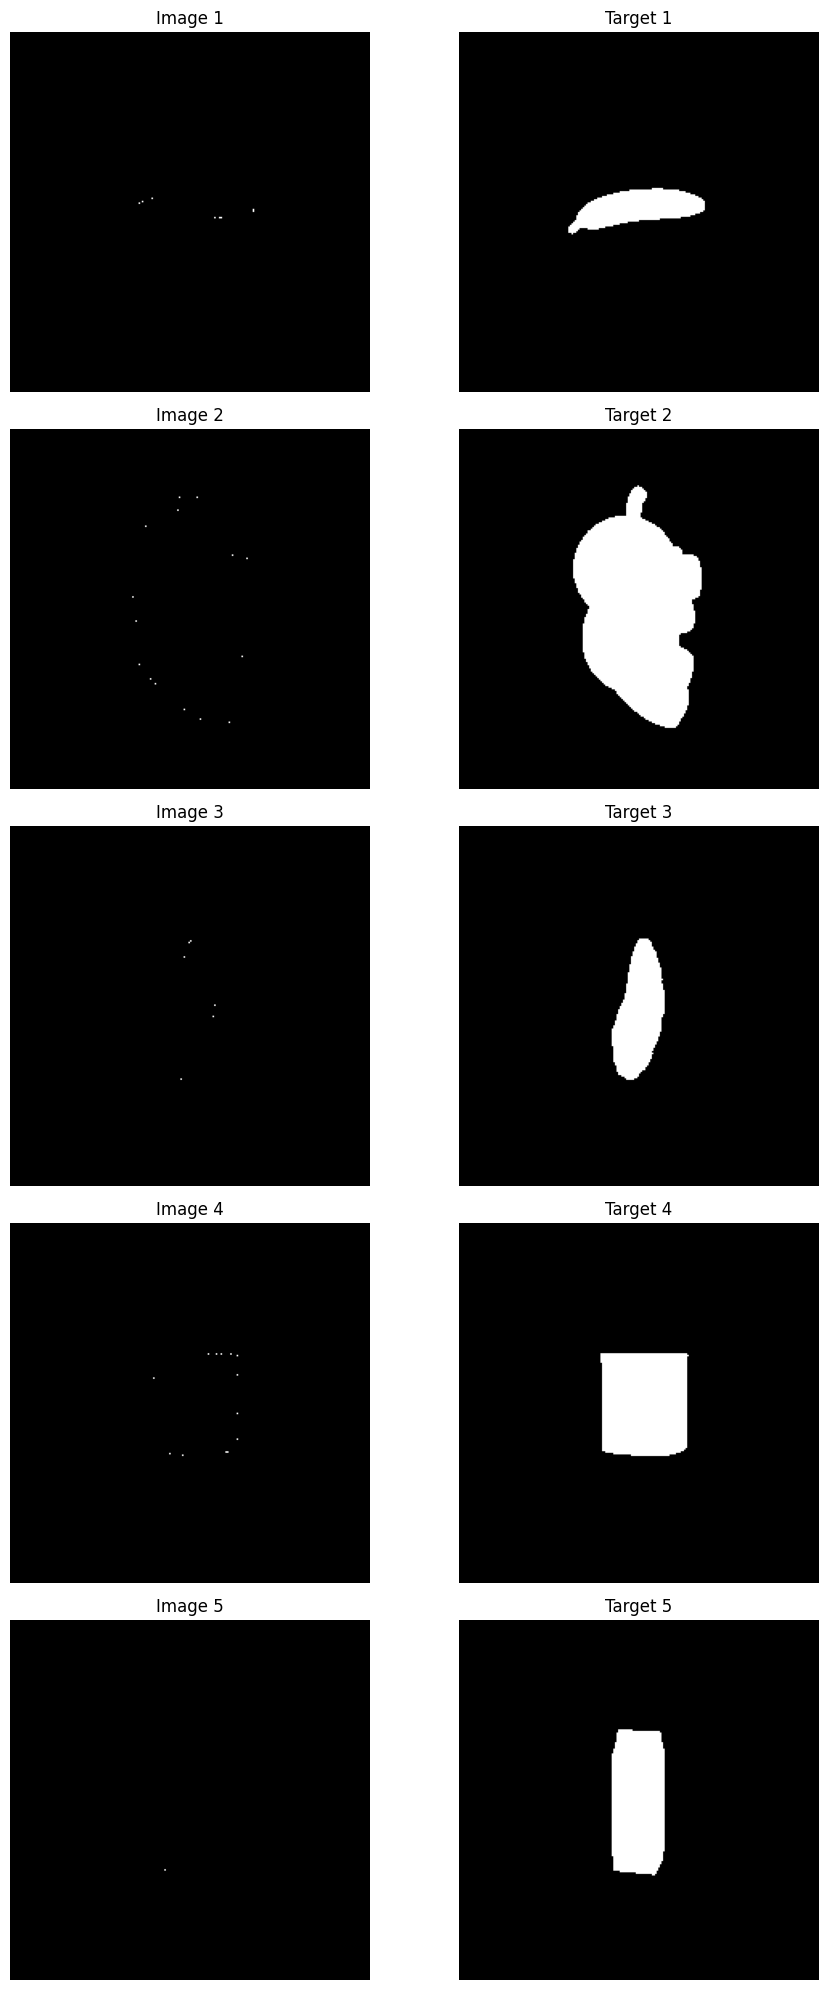

In [3]:
image_dataset = ImageDataset("data", test=True)
# Load 5 random images and targets
fig, axes = plt.subplots(5, 2, figsize=(10, 20))
for i in range(5):
    # Get random image and target
    idx = np.random.randint(0, len(image_dataset))
    image, target = image_dataset[idx]
    
    # Plot image
    axes[i,0].imshow(image[0], cmap='gray')
    axes[i,0].set_title(f'Image {i+1}')
    axes[i,0].axis('off')
    
    # Plot target
    axes[i,1].imshow(target[0], cmap='gray')
    axes[i,1].set_title(f'Target {i+1}')
    axes[i,1].axis('off')

plt.tight_layout()
plt.show()

## Make Prediction
Load random (image, target) pair from the test set and let the model make a prediction.
Plot the original image, the probability heatmap, the binary output as well as the ground truth.

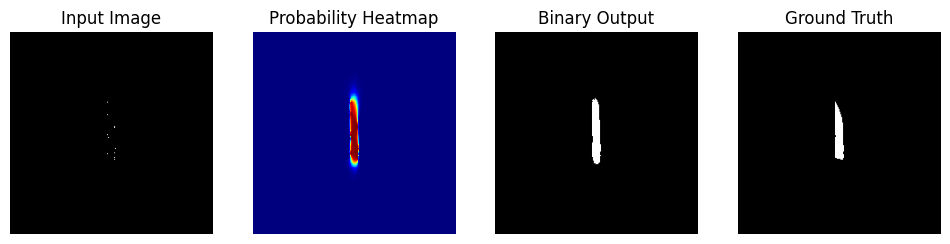

Loss: 0.0063348133116960526


In [41]:
image_dataset = ImageDataset("data", test=True)
# load random image and target
image, target = image_dataset[np.random.randint(0, len(image_dataset))]
image = image.to(device).unsqueeze(0)
target = target.to(device).unsqueeze(0)
target_image = target[0][0].cpu().numpy()

with torch.no_grad():  # Disable gradient calculation for evaluation
    y = model(image)  # Get the model's predictions

y_image = y[0][0].cpu().numpy()
binary_output = (y_image > 0.5).astype(np.uint8)
#show image, probability heatmap and ground truth
plt.figure(figsize=(12, 6))
plt.subplot(1, 4, 1)
plt.imshow(image[0][0].cpu().numpy(), cmap='gray')
plt.title('Input Image')
plt.axis('off')
plt.subplot(1, 4, 2)
plt.imshow(y_image, cmap='jet')
plt.title('Probability Heatmap')
plt.axis('off')
plt.subplot(1, 4, 3)
plt.imshow(binary_output, cmap='gray')
plt.title('Binary Output')
plt.axis('off')
plt.subplot(1, 4, 4)
plt.imshow(target_image, cmap='gray')
plt.title('Ground Truth')
plt.axis('off')
plt.show()

#Calculate loss
loss = torch.nn.BCELoss()
target = transforms.ToTensor()(target_image).unsqueeze(0).to(device)
loss_value = loss(y, target)
print('Loss:', loss_value.item())



In [ ]:
# Initialize lists to store predictions and targets
all_inputs = []
all_preds = []
all_targets = []
all_heatmaps = []
all_losses = []
all_numbers_of_pixels = []

# Evaluate on entire test set
with torch.no_grad():
    for i in range(len(image_dataset)//10):
        if i % 1000 == 0:
            print(f'Processing image {i+1}/{len(image_dataset)}')
        image, target = image_dataset[i]
        all_inputs.append(image[0].numpy())
        number_of_pixels = int(image.sum().item())
        image = image.to(device).unsqueeze(0)
        
        # Get model prediction
        heatmap = model(image)
        loss = torch.nn.BCELoss()
        loss_value = loss(heatmap, target.unsqueeze(0).to(device))
        pred = (heatmap.cpu().numpy() > 0.5).astype(np.uint8)
        
        # Store prediction and target
        all_preds.append(pred[0][0])
        all_heatmaps.append(heatmap[0][0].cpu().numpy())
        all_targets.append(target[0].numpy())
        all_losses.append(loss_value.item())
        all_numbers_of_pixels.append(number_of_pixels)

# Convert lists to numpy arrays
all_preds = np.array(all_preds).flatten()
all_targets = np.array(all_targets).flatten()

Processing image 1/206200
Processing image 1001/206200
Processing image 2001/206200
Processing image 3001/206200
Processing image 4001/206200
Processing image 5001/206200
Processing image 6001/206200
Processing image 7001/206200
Processing image 8001/206200
Processing image 9001/206200
Processing image 10001/206200
Processing image 11001/206200
Processing image 12001/206200
Processing image 13001/206200
Processing image 14001/206200
Processing image 15001/206200
Processing image 16001/206200
Processing image 17001/206200
Processing image 18001/206200
Processing image 19001/206200
Processing image 20001/206200
Mean loss: 0.0499864657138832


Mean loss: 0.0499864657138832
Average Jaccard similarity: 0.6319462045032552
Average loss for 1 pixels: 0.10455565820451543
Average Jaccard similarity for 1 pixels: 0.3338153732006316

Average loss for 5 pixels: 0.05542652211376958
Average Jaccard similarity for 5 pixels: 0.5656124175320079

Average loss for 10 pixels: 0.03610851671706313
Average Jaccard similarity for 10 pixels: 0.7306211950067392

Average loss for 15 pixels: 0.027917525540606745
Average Jaccard similarity for 15 pixels: 0.7988983855643201



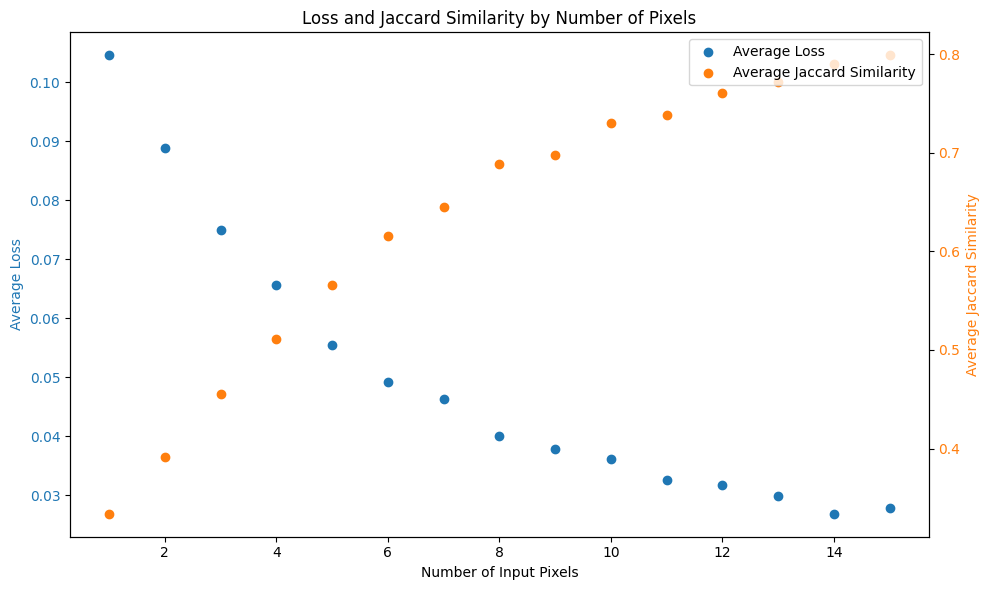

In [33]:
print('Mean loss:', np.mean(all_losses))
all_preds = all_preds.reshape(20620, 224, 224)
all_targets = all_targets.reshape(20620, 224, 224)
all_similarities = []
for i in range(len(all_preds)):
    intersection = np.logical_and(all_preds[i], all_targets[i]).sum()
    union = np.logical_or(all_preds[i], all_targets[i]).sum()
    jaccard = intersection / union
    all_similarities.append(jaccard)
average_jaccard = np.mean(all_similarities)
print('Average Jaccard similarity:', average_jaccard)
# Plot average loss by number of pixels
# Group losses by number of pixels
loss_by_pixels = {}
for pixels, loss in zip(all_numbers_of_pixels, all_losses):
    if pixels not in loss_by_pixels:
        loss_by_pixels[pixels] = []
    loss_by_pixels[pixels].append(loss)
# Plot average jaccard similarity by number of pixels
# Group similarities by number of pixels
similarities_by_pixels = {}
for pixels, similarity in zip(all_numbers_of_pixels, all_similarities):
    if pixels not in similarities_by_pixels:
        similarities_by_pixels[pixels] = []
    similarities_by_pixels[pixels].append(similarity)
# Calculate average similarity for each pixel count
avg_similarity_pixels = []
avg_similarities = []
for pixels, similarities in similarities_by_pixels.items():
    avg_similarity_pixels.append(pixels)
    avg_similarities.append(np.mean(similarities))

# Calculate average loss for each pixel count
avg_pixels = []
avg_losses = []
for pixels, losses in loss_by_pixels.items():
    avg_pixels.append(pixels)
    avg_losses.append(np.mean(losses))

#print average loss and simimlarities for 1, 5, 10 and 15 pixels
for pixels in [1, 5, 10, 15]:
    idx = avg_pixels.index(pixels)
    print(f'Average loss for {pixels} pixels:', avg_losses[idx])
    print(f'Average Jaccard similarity for {pixels} pixels:', avg_similarities[idx])
    print()

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot average loss on primary y-axis
ax1.scatter(avg_pixels, avg_losses, color='tab:blue', label='Average Loss')
ax1.set_xlabel('Number of Input Pixels')
ax1.set_ylabel('Average Loss', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create secondary y-axis for Jaccard similarity
ax2 = ax1.twinx()
ax2.scatter(avg_similarity_pixels, avg_similarities, color='tab:orange', label='Average Jaccard Similarity')
ax2.set_ylabel('Average Jaccard Similarity', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Add title and legend
plt.title('Loss and Jaccard Similarity by Number of Pixels')
fig.legend(loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)

plt.tight_layout()
plt.show()